# Imports

In [5]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

from lib.utils import clean_sentence, clean_text
from lib.preprocess import calc_duration, transform_to_year, aggregate_transactions
from lib.metric import probas2scores, competition_metric, probas2scores_xgb, probas2scores_cv

In [6]:
import pandas as pd
import json
import numpy as np
import re
import pickle
from datetime import datetime
import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

# import nltk
# import deeppavlov
import gensim
import gc
# from pymystem3 import Mystem
from gensim.models.wrappers import FastText

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DataLoading

In [7]:
DATA_PATH = '../data_like/'

In [8]:
X = np.load("../PreprocessedData/FinalDataset/train_data.npy")
y = np.load("../PreprocessedData/FinalDataset/train_labels.npy")
test = np.load("../PreprocessedData/FinalDataset/test_data.npy")
order = np.load("../PreprocessedData/FinalDataset/test_labels.npy")

In [ ]:
# DataPreprocess

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=44)

In [9]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)

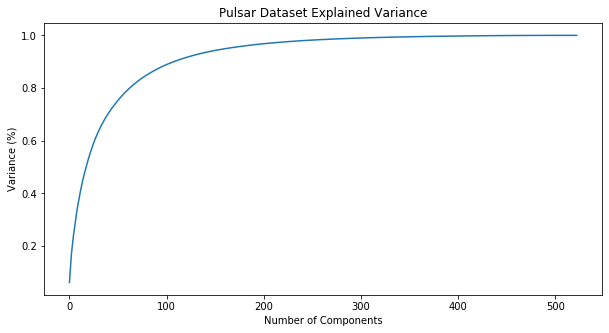

In [10]:
#Fitting the PCA algorithm with our Data
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X)
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [11]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X_train)
pca = PCA(n_components=250).fit(data_rescaled)
X_train_pca = pca.transform(data_rescaled)
data_rescaled = scaler.transform(X_val)
X_val_pca = pca.transform(data_rescaled)

In [12]:
X_train_pca.shape

(354855, 250)

# Training model

In [9]:
parameters = {'learning_rate': [0.5, 0.1, 0.01],
              'max_depth': [6, 8, 10],
              'n_estimators': [50, 100, 250, 500]
             }

In [ ]:
estimator = XGBClassifier(n_jobs=2)
clf = GridSearchCV(estimator, param_grid=parameters, scoring='f1_weighted', n_jobs=6, cv=5, verbose=5)
clf.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [14]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=12,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Evaluating model

0.6

In [15]:
sum(model.predict(X_val) == y_val) / len(y_val)

0.6001301929222393

In [16]:
sum(model.predict(X_train) == y_train) / len(y_train)

0.6530188386805879

Посмотреть f1_score

In [18]:
model.classes_

array(['dislike', 'like', 'skip', 'view'], dtype='<U7')

In [148]:
labels = model.predict(X_val)
probas = model.predict_proba(X_val)
scores = probas2scores_xgb(labels, probas)

In [142]:
np.argmax(probas, axis=1)

array([3, 3, 3, ..., 3, 2, 2])

In [143]:
labels

array(['view', 'view', 'view', ..., 'view', 'skip', 'skip'], dtype='<U7')

In [131]:
scores_new = []
for s in scores:
    if abs(s) > 0.4:
        scores_new.append(s / abs(s))
    else:
        scores_new.append(s*1.3)

In [132]:
f1_score(y_val, labels, labels=model.classes_, average='weighted')

0.5672487919099328

In [149]:
probas2scores_cv(probas) / len(probas)

0.20225129018092644

In [152]:
model.classes_

array(['dislike', 'like', 'skip', 'view'], dtype='<U7')

In [151]:
print('old:', competition_metric(labels, scores) / len(scores))
print('new:', competition_metric(labels, scores_new) / len(scores_new))

old: 0.07104604981817485
new: 0.12031324447293429


old: 0.07104604981817485 <br>
new: 0.12031324447293429

# Submission

In [107]:
labels = model.predict(test)
probas = model.predict_proba(test)
scores = probas2scores_xgb(labels, probas)

In [108]:
scores_new = []
for s in scores:
    if s > 0.4:
        scores_new.append(1)
    else:
        scores_new.append(s)

In [109]:
scores = scores_new

In [110]:
submission = pd.DataFrame(np.array([order, scores]).T, columns=['answer_id', 'score'])

In [53]:
submission = submission.sort_values(by='answer_id')

In [54]:
submission.answer_id = submission.answer_id.astype(dtype=np.int32)

In [111]:
submission.to_csv('../submission.csv', index=False, sep=',')

In [57]:
submission

,answer_id,score
0,0,0.570386
1,1,0.500894
2,2,0.518793
3,3,0.756058
4,4,0.555386
...,...,...
172044,172044,0.592557
172045,172045,-0.464492
172046,172046,0.776583
172047,172047,0.585835


In [45]:
a = pd.read_csv('../submission.csv')

In [46]:
a.head()

,answer_id,scores
0,0,"0,5703859329223633"
1,1,"0,5008941888809204"
2,2,"0,5187928080558777"
3,3,"0,756057620048523"
4,4,"0,5553862452507019"


In [48]:
a = pd.read_csv('../data_like/sample_submit.csv')

In [49]:
a.head()

,answer_id,score
0,0,0.85
1,1,0.53
2,2,-0.89
3,3,0.54
4,4,0.34
